In [1]:
import json
from pathlib import Path
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
from stdp.spike_timing_entropy import *
from stdp.ensemble_readout import *

In [2]:
# entropy calculation
from entropy.entropy import EntropyCalculator
import antropy as ant
entropy_calculator = EntropyCalculator()
def mi_matrix(output_spikes, input_spikes):
    """
    Calculate the mutual information of the model.
    Calculation includes the MI for each output neuron and the overall MI of the model.
    
    Formula: I(S;R) = ∑p(s,r) log(p(s,r)/(p(s)p(r)))
    
    where:
        - S is the input spikes
        - R is the output spikes
        - p(s,r) is the joint probability of input and output spikes
        - p(s) is the marginal probability of input spikes
        - p(r) is the marginal probability of output spikes

    Args:
        output_spikes (list): Spikes from the output layer.
        input_spikes (list): Spikes from the input layer.

    Returns:
        np.ndarray: List of MI (neuron0, neuron1, overall).
    """
    output_spikes = np.array(output_spikes)
    input_spikes = np.array(input_spikes)

    mi = []

    for input_spike in input_spikes:
        if not isinstance(input_spike, np.ndarray):
            raise ValueError("Input spikes must be a numpy array.")
        
        for output_spike in output_spikes:
            if not isinstance(output_spike, np.ndarray):
                raise ValueError("Output spikes must be a numpy array.")
            mi.append(entropy_calculator.mutual_information(input_spike, output_spike))

    return np.mean(np.asarray(mi), axis=0)

def hc_matrix(output_spikes, input_spikes):
    """
    Calculate the conditional entropy of the model.
    Calculation includes the conditional entropy for each output neuron and the overall conditional entropy of the model.
    
    Formula: H(R|S) = -∑p(s)∑p(r|s) log(p(r|s))
    
    Args:
        output_spikes (list): Spikes from the output layer.
        input_spikes (list): Spikes from the input layer.

    Returns:
        np.ndarray: List of entropies (neuron0, neuron1, overall).
    """
    output_spikes = np.array(output_spikes)
    input_spikes = np.array(input_spikes)
    
    hc = []
    
    for input_spike in input_spikes:
        if not isinstance(input_spike, np.ndarray):
            raise ValueError("Input spikes must be a numpy array.")

        for output_spike in output_spikes:
            if not isinstance(output_spike, np.ndarray):
                raise ValueError("Output spikes must be a numpy array.")

            hc.append(entropy_calculator.conditional_entropy(output_spike, input_spike))

    return np.mean(np.asarray(hc), axis=0)

def permutation_matrix(output_spikes, order=3, delay=1, normalize=True):

    PEs = [ant.perm_entropy(output_spikes[n], order=order, delay=delay, normalize=normalize) for n in range(output_spikes.shape[0])]

    return np.mean(np.asarray(PEs), axis=0)

In [3]:
EPS = 1e-9

def predict_first(out_ids, out_t, Np):
    if out_ids.size == 0: return 0
    t0 = out_t[out_ids < Np].min() if np.any(out_ids < Np) else np.inf
    t1 = out_t[out_ids >= Np].min() if np.any(out_ids >= Np) else np.inf
    if np.isinf(t0) and np.isinf(t1): return 0
    return 0 if t0 <= t1 else 1

def predict_weighted(out_ids, out_t, Np, tau=30.0):
    if out_ids.size == 0: return 0
    s0 = np.exp(-out_t[out_ids <  Np]/tau).sum()
    s1 = np.exp(-out_t[out_ids >= Np]/tau).sum()
    return 0 if s0 >= s1 else 1

def predict_raceN(out_ids, out_t, Np, N=3):
    if out_ids.size == 0: return 0
    order = np.argsort(out_t)
    c0=c1=0
    for k in order:
        if out_ids[k] < Np: c0+=1
        else: c1+=1
        if c0>=N or c1>=N:
            return 0 if c0>c1 else 1
    return 0 if (out_ids < Np).sum() >= (out_ids >= Np).sum() else 1

def predict_count(out_ids, Np):
    if out_ids.size == 0: return 0
    return 0 if (out_ids < Np).sum() >= (out_ids >= Np).sum() else 1

def eval_all(events, labels, Np, tau=30.0, N=3):
    y = np.asarray(labels, dtype=int)
    acc = {}
    preds = {}
    for name in ["count", "weighted", "first", "raceN"]:
        yh = []
        for ids, t in events:
            ids = np.asarray(ids); t = np.asarray(t, dtype=float)
            if name=="count":   p = predict_count(ids, Np)
            elif name=="first": p = predict_first(ids, t, Np)
            elif name=="raceN": p = predict_raceN(ids, t, Np, N=N)
            else:               p = predict_weighted(ids, t, Np, tau=tau)
            yh.append(p)
        yh = np.asarray(yh, dtype=int)
        preds[name] = yh
        acc[name] = float((yh == y).mean())
    ens = (preds["count"] + preds["weighted"] + preds["first"] + preds["raceN"]) >= 2
    acc["ensemble"] = float((ens.astype(int) == y).mean())
    return acc

In [20]:
def load_npz_folder(folder, x_key="spike_matrix", label_key="label", C=None, T=None, strict=False):
    folder = Path(folder); files = sorted(folder.glob("*.npz"))
    if not files: raise FileNotFoundError(f"No .npz in {folder}")
    X, y = [], []
    for f in files:
        data = np.load(f, allow_pickle=False)
        if x_key not in data or label_key not in data:
            print(f"[WARN] Skip {f.name}: missing keys"); continue
        x = data[x_key]; lbl = data[label_key]
        lbl = int(lbl) if not isinstance(lbl, np.ndarray) else int(np.ravel(lbl)[0])
        if x.ndim != 2: 
            print(f"[WARN] Skip {f.name}: x must be 2D (C,T), got {x.shape}"); continue
        Cx, Tx = x.shape
        if strict and ((C is not None and Cx != C) or (T is not None and Tx != T)):
            print(f"[WARN] Skip {f.name}: expected ({C},{T}), got {x.shape}"); continue
        X.append(x.astype(np.int8)); y.append(lbl)
    if not X: raise RuntimeError("No valid samples loaded.")
    X, y = np.array(X, dtype=np.int8), np.array(y, dtype=int)
    if C is None or T is None: C, T = X.shape[1], X.shape[2]
    return X, y, int(C), int(T)

def stratified_split_indices(y, val_split=0.2, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y, dtype=int)
    idx = np.arange(len(y))
    idx_train, idx_val = [], []
    classes = np.unique(y)
    for c in classes:
        idc = idx[y==c]
        rng.shuffle(idc)
        n = len(idc)
        n_val  = int(round(n*val_split))
        n_train = n - n_val
        idx_val.extend(idc[:n_val])
        idx_train.extend(idc[n_val:])
    # shuffle each split for decorrelation
    rng.shuffle(idx_train); rng.shuffle(idx_val)
    return np.array(idx_train), np.array(idx_val)

def make_spike_indices(X, dt_ms=1.0):
    C, T = X.shape
    ch, tbin = np.where(X > 0)
    times = (tbin.astype(float) * dt_ms)
    return ch.astype(int), times

def spikes_from_matrix(binmat, dt_ms):
    ch, t = np.where(binmat > 0)
    if ch.size == 0: return np.array([], dtype=int), np.array([], dtype=float)
    times_ms = (t.astype(np.float64) * dt_ms)
    return ch.astype(int), times_ms

def build_net(C, Np, params):
    start_scope()
    
    np.random.seed(params["seed"])
    
    defaultclock.dt = params["dt_ms"]*ms

    # Input spike generator
    G_in = SpikeGeneratorGroup(C, indices=np.array([], dtype=int), times=np.array([])*ms)

    # Two output pops (class 0 & 1)
    eqs = '''
    dv/dt = (-(v - v_rest) + ge - gi + I_bias + I_drive)/tau_m : 1 (unless refractory)
    dge/dt = -ge/tau_e : 1
    dgi/dt = -gi/tau_i : 1
    I_drive : 1
    v_rest : 1
    v_th   : 1
    v_reset: 1
    tau_m  : second
    tau_e  : second
    tau_i  : second
    I_bias : 1
    '''
    G0 = NeuronGroup(Np, eqs, threshold="v>v_th", reset="v=v_reset", refractory=params["t_ref"]*ms, method="euler")
    G1 = NeuronGroup(Np, eqs, threshold="v>v_th", reset="v=v_reset", refractory=params["t_ref"]*ms, method="euler")
    for G in (G0, G1):
        G.v = params["v_reset"]
        G.v_rest = params["v_rest"]
        G.v_th = params["v_th"]
        G.v_reset = params["v_reset"]
        G.tau_m = params["tau_m"]*ms
        G.tau_e = params["tau_e"]*ms
        G.tau_i = params["tau_i"]*ms
        G.I_bias = params["i_bias"]
        G.I_drive = 0.0

    # Input -> Output synapses with pair-based STDP (rename taupre/taupost to avoid _post suffix conflict)
    stdp_model = '''
    w : 1
    Apre : 1
    Apost : 1
    taupre : second
    taupost: second
    dApre  : 1
    dApost : 1
    wmax   : 1
    plastic : 1
    '''
    on_pre = '''
    ge_post += w
    Apre = Apre*exp(-dt/taupre) + dApre
    w = clip(w + Apost * plastic, 0, wmax)
    '''
    on_post = '''
    Apost = Apost*exp(-dt/taupost) + dApost
    w = clip(w + Apre * plastic, 0, wmax)
    '''
    S0 = Synapses(G_in, G0, model=stdp_model, on_pre=on_pre, on_post=on_post)
    S1 = Synapses(G_in, G1, model=stdp_model, on_pre=on_pre, on_post=on_post)
    S0.connect(True)
    S1.connect(True)
    for S in (S0, S1):
        S.w = np.random.uniform(0.0, params["w_init"], size=len(S.w))
        S.dApre = params["eta"]
        S.dApost = -params["eta"]*params["beta"]
        S.taupre = params["tau_pre"]*ms
        S.taupost = params["tau_post"]*ms
        S.wmax = params["wmax"]

    # Inhibition
    I0 = I1 = None
    X01 = X10 = None
    if params["inh_w"] > 0:
        I0 = Synapses(G0, G0, model="w_inh:1", on_pre="gi_post += w_inh")
        I0.connect(condition="i!=j"); I0.w_inh = params["inh_w"]
        I1 = Synapses(G1, G1, model="w_inh:1", on_pre="gi_post += w_inh")
        I1.connect(condition="i!=j"); I1.w_inh = params["inh_w"]
    if params["cross_inh_w"] > 0:
        X01 = Synapses(G0, G1, model="w_inh:1", on_pre="gi_post += w_inh")
        X01.connect(True); X01.w_inh = params["cross_inh_w"]
        X10 = Synapses(G1, G0, model="w_inh:1", on_pre="gi_post += w_inh")
        X10.connect(True); X10.w_inh = params["cross_inh_w"]

    # Monitors
    M0 = SpikeMonitor(G0)
    M1 = SpikeMonitor(G1)

    net = Network(G_in, G0, G1, S0, S1, M0, M1)
    if I0: net.add(I0, I1)
    if X01: net.add(X01, X10)
    return net, G_in, G0, G1, S0, S1, M0, M1

def normalize_columns(S, target_sum=1.0):
    w = S.w[:].copy()
    j = S.j[:]
    n_post = int(j.max())+1 if j.size>0 else 0
    if n_post == 0: return
    sums = np.zeros(n_post, dtype=float)
    for idx, jj in enumerate(j): sums[jj] += w[idx]
    scale = np.ones_like(sums)
    nz = sums > 0
    scale[nz] = target_sum / sums[nz]
    for idx, jj in enumerate(j):
        w[idx] = np.clip(w[idx] * scale[jj], 0.0, float(S.wmax[0]))
    S.w[:] = w

def syn_to_matrix(S, C, Np):
    W = np.zeros((C, Np), dtype=float)
    i = np.asarray(S.i[:])
    j = np.asarray(S.j[:])
    w = np.asarray(S.w[:])
    if i.size:
        W[i, j] = w

    return W

def class_counts_by_mapping(M_out, t_start, t_end, mapping, Nout):
    mask = (M_out.t/ms >= t_start) & (M_out.t/ms < t_end)
    ids = np.array(M_out.i[mask], dtype=int)
    if ids.size == 0: return [0, 0]
    cls_ids = mapping[ids]
    c0 = int(np.sum(cls_ids == 0)); c1 = int(np.sum(cls_ids == 1))
    return [c0, c1]

def per_neuron_hist(M_out, t_start, t_end, Nout):
    mask = (M_out.t/ms >= t_start) & (M_out.t/ms < t_end)
    ids = np.array(M_out.i[mask], dtype=int)
    if ids.size == 0: return np.zeros(Nout, dtype=int)
    return np.bincount(ids, minlength=Nout).astype(int)

def epoch_entropy(events, labels, xs, params):
    epoch_result = {
        "model": {
            "shannon_entropy": 0.0,
            "entropy_rate": 0.0,
            "mutual_information": 0.0,
            "conditional_entropy": 0.0,
            "permutation_entropy": 0.0,
            "avg_spike_count": 0,
            "H_M": 0.0,
        },
        "group_0": {
            "shannon_entropy": 0.0,
            "entropy_rate": 0.0,
            "mutual_information": 0.0,
            "conditional_entropy": 0.0,
            "permutation_entropy": 0.0,
            "avg_spike_count": 0,
            "H_M_given0": 0.0,
        },
        "group_1": {
            "shannon_entropy": 0.0,
            "entropy_rate": 0.0,
            "mutual_information": 0.0,
            "conditional_entropy": 0.0,
            "permutation_entropy": 0.0,
            "avg_spike_count": 0,
            "H_M_given1": 0.0,
        },
        "MI": 0.0
    }
    
    val_entropy = {
            "group_0": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "permutation_entropy": [],
                "spike_count": []
            },
            "group_1": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "permutation_entropy": [],
                "spike_count": []
            },
            "model": {
                "shannon_entropy": [],
                "entropy_rate": [],
                "mutual_information": [],
                "conditional_entropy": [],
                "permutation_entropy": [],
                "spike_count": []
            }
        }

    # me = margin_entropy(events, labels, params["out_pop"], params["readout_tau"], bins="fd")

    for i in range(len(events)):
        out_neuron, out_t_ms = events[i]
        bins = np.floor(out_t_ms / params["dt_ms"]).astype(int)
        bins = np.clip(bins, 0, params["time"]-1)
        out_spike = np.zeros((2 * params["out_pop"], params["time"]), dtype=int)
        np.add.at(out_spike, (out_neuron, bins), 1)
        out_spike = (out_spike > 0).astype(int)

        out_spike0 = out_spike[0:params["out_pop"], :]
        val_entropy["group_0"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike0))
        val_entropy["group_0"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike0))
        val_entropy["group_0"]["permutation_entropy"].append(permutation_matrix(out_spike0))
        val_entropy["group_0"]["mutual_information"].append(mi_matrix(out_spike0, xs[i]))
        val_entropy["group_0"]["conditional_entropy"].append(hc_matrix(out_spike0, xs[i]))
        val_entropy["group_0"]["spike_count"].append(np.sum(out_spike0))

        out_spike1 = out_spike[params["out_pop"]:2*params["out_pop"], :]
        val_entropy["group_1"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike1))
        val_entropy["group_1"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike1))
        val_entropy["group_1"]["permutation_entropy"].append(permutation_matrix(out_spike1))
        val_entropy["group_1"]["mutual_information"].append(mi_matrix(out_spike1, xs[i]))
        val_entropy["group_1"]["conditional_entropy"].append(hc_matrix(out_spike1, xs[i]))
        val_entropy["group_1"]["spike_count"].append(np.sum(out_spike1))

        val_entropy["model"]["shannon_entropy"].append(entropy_calculator.shannon_entropy(out_spike))
        val_entropy["model"]["entropy_rate"].append(entropy_calculator.entropy_rate(out_spike))
        val_entropy["model"]["permutation_entropy"].append(permutation_matrix(out_spike))
        val_entropy["model"]["mutual_information"].append(mi_matrix(out_spike, xs[i]))
        val_entropy["model"]["conditional_entropy"].append(hc_matrix(out_spike, xs[i]))
        val_entropy["model"]["spike_count"].append(np.sum(out_spike))
    
    epoch_result["model"]["shannon_entropy"] = np.mean(val_entropy["model"]["shannon_entropy"])
    epoch_result["model"]["entropy_rate"] = np.mean(val_entropy["model"]["entropy_rate"])
    epoch_result["model"]["mutual_information"] = np.mean(val_entropy["model"]["mutual_information"])
    epoch_result["model"]["conditional_entropy"] = np.mean(val_entropy["model"]["conditional_entropy"])
    epoch_result["model"]["permutation_entropy"] = np.mean(val_entropy["model"]["permutation_entropy"])
    epoch_result["model"]["avg_spike_count"] = np.mean(val_entropy["model"]["spike_count"])
    # epoch_result["model"]["H_M"] = me["H_M"]
    
    epoch_result["group_0"]["shannon_entropy"] = np.mean(val_entropy["group_0"]["shannon_entropy"])
    epoch_result["group_0"]["entropy_rate"] = np.mean(val_entropy["group_0"]["entropy_rate"])
    epoch_result["group_0"]["mutual_information"] = np.mean(val_entropy["group_0"]["mutual_information"])
    epoch_result["group_0"]["conditional_entropy"] = np.mean(val_entropy["group_0"]["conditional_entropy"])
    epoch_result["group_0"]["permutation_entropy"] = np.mean(val_entropy["group_0"]["permutation_entropy"])
    epoch_result["group_0"]["avg_spike_count"] = np.mean(val_entropy["group_0"]["spike_count"])
    # epoch_result["group_0"]["H_M_given0"] = me["H_M_given0"]

    epoch_result["group_1"]["shannon_entropy"] = np.mean(val_entropy["group_1"]["shannon_entropy"])
    epoch_result["group_1"]["entropy_rate"] = np.mean(val_entropy["group_1"]["entropy_rate"])
    epoch_result["group_1"]["mutual_information"] = np.mean(val_entropy["group_1"]["mutual_information"])
    epoch_result["group_1"]["conditional_entropy"] = np.mean(val_entropy["group_1"]["conditional_entropy"])
    epoch_result["group_1"]["permutation_entropy"] = np.mean(val_entropy["group_1"]["permutation_entropy"])
    epoch_result["group_1"]["avg_spike_count"] = np.mean(val_entropy["group_1"]["spike_count"])
    # epoch_result["group_1"]["H_M_given1"] = me["H_M_given1"]
    
    # epoch_result["MI"] = me["MI"]

    return epoch_result

def run_epoch(net, X, y, G_in, G0, G1, S0, S1, M0, M1, params, subset=None, teacher=False, eval=False):
    C, T = X.shape[1], X.shape[2]
    dt_ms = params["dt_ms"]
    events = []
    labels = []
    xs = []
    dW0 = 0.0
    dW1 = 0.0
    dW = 0.0
    no_spike = 0
    total_spikes = 0

    idx = subset if subset is not None else np.arange(len(X), dtype=int)
    
    if eval:
        W0_prev = S0.w[:].copy()
        W1_prev = S1.w[:].copy()

    for k in idx:
        x = X[k]
        label = int(y[k])
        # reset
        for G in (G0, G1):
            G.I_drive = 0.0
            G.v = params["v_reset"]
            G.ge = 0
            G.gi = 0

        ind, tms = make_spike_indices(x, dt_ms=dt_ms)
        G_in.set_spikes(ind, (tms + float(net.t/ms))*ms)

        if teacher:
            if label == 0: 
                G0.I_drive = params["teacher_i"]
            else:          
                G1.I_drive = params["teacher_i"]
            net.run(params["teach_ms"]*ms)
            G0.I_drive = 0.0
            G1.I_drive = 0.0
            rem = max(0.0, T*dt_ms - params["teach_ms"])
            if rem > 0: 
                net.run(rem*ms)
        else:
            net.run((T*dt_ms)*ms)

        # collect spikes in last window
        t0 = float(net.t/ms) - T*dt_ms
        ids0 = M0.i[(M0.t/ms >= t0) & (M0.t/ms < t0 + T*dt_ms)]
        t0s  = M0.t[(M0.t/ms >= t0) & (M0.t/ms < t0 + T*dt_ms)]/ms
        ids1 = M1.i[(M1.t/ms >= t0) & (M1.t/ms < t0 + T*dt_ms)]
        t1s  = M1.t[(M1.t/ms >= t0) & (M1.t/ms < t0 + T*dt_ms)]/ms

        out_ids = np.concatenate([np.array(ids0), params["out_pop"] + np.array(ids1)]).astype(int)
        out_t   = np.concatenate([np.array(t0s) - t0, np.array(t1s) - t0]).astype(float)

        events.append((out_ids, out_t))
        labels.append(label)
        xs.append(x)
        total_spikes += out_ids.size
        if out_ids.size == 0: no_spike += 1

        # normalize weights
        normalize_columns(S0, target_sum=params["w_norm"])
        normalize_columns(S1, target_sum=params["w_norm"])

    acc = eval_all(events, labels, params["out_pop"], tau=params["readout_tau"], N=params["race_N"])
    diag = {"mean_spikes": total_spikes/float(len(idx)+EPS), "no_spike_pct": 100.0*no_spike/float(len(idx))}
    
    if eval:
        epoch_entropy_ = epoch_entropy(events, labels, xs, params)
        W0_post = S0.w[:].copy()
        W1_post = S1.w[:].copy()
        dW0 = float(np.mean(np.abs(W0_post - W0_prev)))
        dW1 = float(np.mean(np.abs(W1_post - W1_prev)))
        dW = (dW0 + dW1) / 2.0

        weight_change = {"dW0": dW0, "dW1": dW1, "dW": dW}
        return events, labels, acc, diag, epoch_entropy_, weight_change
    else:
        return events, labels, acc, diag

def run_raster(net, G_in, G0, G1, S0, S1, M0, M1, params, file_path):
    
    # load file 
    data = np.load(file_path, allow_pickle=False)
    x = data[params["x_key"]]
    y = int(data[params["label_key"]])
    dt_ms = params["dt_ms"]
    
    for G in (G0, G1):
        G.I_drive = 0.0
        G.v = params["v_reset"]
        G.ge = 0
        G.gi = 0

    ind, tms = make_spike_indices(x, dt_ms=dt_ms)
    G_in.set_spikes(ind, (tms + float(net.t/ms))*ms)
    net.run((params["time"]*dt_ms)*ms)

    t0 = float(net.t/ms) - params["time"]*dt_ms
    ids0 = M0.i[(M0.t/ms >= t0) & (M0.t/ms < t0 + params["time"]*dt_ms)]
    t0s  = M0.t[(M0.t/ms >= t0) & (M0.t/ms < t0 + params["time"]*dt_ms)]/ms
    ids1 = M1.i[(M1.t/ms >= t0) & (M1.t/ms < t0 + params["time"]*dt_ms)]
    t1s  = M1.t[(M1.t/ms >= t0) & (M1.t/ms < t0 + params["time"]*dt_ms)]/ms

    out_ids = np.concatenate([np.array(ids0), params["out_pop"] + np.array(ids1)]).astype(int)
    out_t   = np.concatenate([np.array(t0s) - t0, np.array(t1s) - t0]).astype(float)

    return out_ids, out_t

def train_and_eval(params):
    
    val_hist = []
    entropy_hist = []
    weight_changes = []
    raster_class0 = []
    raster_class1 = []

    Xall, yall, C, T = load_npz_folder(params["NPZ_DIR"], params["x_key"], params["label_key"],
                                 C=params["channels"], T=params["time"], strict=params["strict_shape"])
    print(f"Loaded {len(Xall)} samples, shape = ({C},{T}), labels 0/1")

    idx_tr, idx_va = stratified_split_indices(yall, val_split=params["val_split"], seed=params["seed"])
    Xtr, ytr = Xall[idx_tr], yall[idx_tr]
    Xva, yva = Xall[idx_va], yall[idx_va]

    net, G_in, G0, G1, S0, S1, M0, M1 = build_net(C, params["out_pop"], params)

    np.random.seed(params["seed"])
    
    S0.plastic = 0
    S1.plastic = 0
    out_ids_class0_pre, out_t_class0_pre = run_raster(net, G_in, G0, G1, S0, S1, M0, M1, params,
                                                      "spike_data/raster_plot/class0_0000.npz")
    raster_class0.append((out_ids_class0_pre, out_t_class0_pre))
    out_ids_class1_pre, out_t_class1_pre = run_raster(net, G_in, G0, G1, S0, S1, M0, M1, params,
                                                      "spike_data/raster_plot/class1_0000.npz")
    raster_class1.append((out_ids_class1_pre, out_t_class1_pre))
    S0.plastic = 1
    S1.plastic = 1

    for ep in range(1, params["epochs"]+1):
        # balanced subset for training
        n = min(params["epoch_samples"], len(Xtr))
        if params["balance_train"]:
            idx0 = np.where(ytr==0)[0]
            idx1 = np.where(ytr==1)[0]
            n0 = n//2; n1 = n - n0
            sel = np.concatenate([
                np.random.choice(idx0, size=min(n0, len(idx0)), replace=len(idx0)<n0),
                np.random.choice(idx1, size=min(n1, len(idx1)), replace=len(idx1)<n1),
            ])
            np.random.shuffle(sel)
        else:
            sel = np.random.choice(np.arange(len(Xtr)), size=n, replace=False)

        # TRAIN
        tr_events, tr_labels, tr_acc, tr_diag = run_epoch(net, Xtr, ytr, G_in, G0, G1, S0, S1, M0, M1, params, subset=sel, teacher=True, eval=False)

        # VALIDATION
        if params["balance_val"]:
            idv0 = np.where(yva==0)[0]
            idv1 = np.where(yva==1)[0]
            nV = len(Xva)
            nv0 = nV//2
            nv1 = nV - nv0
            selV = np.concatenate([
                np.random.choice(idv0, size=min(nv0, len(idv0)), replace=len(idv0)<nv0),
                np.random.choice(idv1, size=min(nv1, len(idv1)), replace=len(idv1)<nv1),
            ]); np.random.shuffle(selV)
        else:
            selV = np.arange(len(Xva), dtype=int)
        va_events, va_labels, va_acc, va_diag, epoch_entropy, w_change = run_epoch(net, Xva, yva, G_in, G0, G1, S0, S1, M0, M1, params, subset=selV, teacher=False, eval=True)
        weight_changes.append(w_change)

        val_hist.append(va_acc)
        entropy_hist.append(epoch_entropy)

        print(f"[Epoch {ep:2d}/{params['epochs']}] "
              f"Train acc | count: {tr_acc['count']:.3f} | weighted: {tr_acc['weighted']:.3f} | first: {tr_acc['first']:.3f} | raceN: {tr_acc['raceN']:.3f} | ensemble: {tr_acc['ensemble']:.3f}")
        print(f"                     [Val] acc | count: {va_acc['count']:.3f} | weighted: {va_acc['weighted']:.3f} | first: {va_acc['first']:.3f} | raceN: {va_acc['raceN']:.3f} | ensemble: {va_acc['ensemble']:.3f}")
        print(f"           [Diag] train mean spk: {tr_diag['mean_spikes']:.1f} | train no-spike%: {tr_diag['no_spike_pct']:.1f}% | val mean spk: {va_diag['mean_spikes']:.1f} | val no-spike%: {va_diag['no_spike_pct']:.1f}%")
        print(f"           [Diag] weight change | dW0: {w_change['dW0']:.6f} | dW1: {w_change['dW1']:.6f} | dW: {w_change['dW']:.6f}")


        # Teacher schedule: decay after each epoch (prevents overfit to teacher)
        params['teacher_i'] = max(0.1, params['teacher_i'] * 0.9)
        # print(f"[Sched] teacher_i -> {params['teacher_i']:.3f}")

        # simple LR decay
        if ep in {10, 15, 20}:
            for S in (S0, S1):
                S.dApre[:]  *= 0.5
                S.dApost[:] *= 0.5


        # --- Auto-boost excitability if network is too silent ---
        if tr_diag['no_spike_pct'] > 50.0 or va_diag['no_spike_pct'] > 50.0:
            # lower threshold and increase teacher drive a bit (capped)
            params['v_th'] = max(0.30, params['v_th'] - 0.02)
            params['teacher_i'] = min(1.0, params['teacher_i'] * 1.2)
            G0.v_th = params['v_th']; G1.v_th = params['v_th']
            # print(f"[Auto] Lower v_th -> {params['v_th']:.3f}, raise teacher_i -> {params['teacher_i']:.2f}")
        elif tr_diag['mean_spikes'] > 80.0 or va_diag['mean_spikes'] > 80.0:
            # too active -> slightly raise threshold
            params['v_th'] = min(1.0, params['v_th'] + 0.02)
            G0.v_th = params['v_th']; G1.v_th = params['v_th']
            # print(f"[Auto] Raise v_th -> {params['v_th']:.3f}")

    print("[Done]")
    
    S0.plastic = 0
    S1.plastic = 0

    out_ids_class0_post, out_t_class0_post = run_raster(net, G_in, G0, G1, S0, S1, M0, M1, params,
                                                      "spike_data/raster_plot/class0_0000.npz")
    raster_class0.append((out_ids_class0_post, out_t_class0_post))

    out_ids_class1_post, out_t_class1_post = run_raster(net, G_in, G0, G1, S0, S1, M0, M1, params,
                                                      "spike_data/raster_plot/class1_0000.npz")
    raster_class1.append((out_ids_class1_post, out_t_class1_post))

    return val_hist, entropy_hist, weight_changes, raster_class0, raster_class1

In [21]:
params = {
    "NPZ_DIR": Path("/Users/minhhieunguyen/Documents/Projects/Dissertation/Code/spike_data/syn"),
    "x_key": "spike_matrix",
    "label_key": "label",
    "channels": 32,
    "time": 100,
    "strict_shape": True,
    "dt_ms": 1.0,
    "epochs": 30,
    "seed": 42,
    "out_pop": 8,
    "epoch_samples": 256,
    "balance_train": True,
    "balance_val": True,
    "train_split": 0.8,
    "val_split": 0.2,

    # neuron parameters
    "v_th": 0.48,
    "v_rest": 0.0,
    "v_reset": 0.0,
    "tau_m": 20.0,
    "tau_e": 15.0,
    "tau_i": 10.0,
    "t_ref": 1.0,
    "i_bias": 0.1,
    
    # STDP
    "eta": 0.01,
    "beta": 0.9,
    "tau_pre": 20,
    "tau_post": 20,
    "wmax": 3.0,
    "w_init": 0.65,
    "w_norm": 8,
    
    # inhibition
    "inh_w": 0.65,
    "cross_inh_w": 0.3,
    
    # teacher
    "teacher_i": 0.3,
    "teach_ms": 12,
    "teach_delay": 2,
    
    # readout
    "readout_tau": 30,
    "race_N": 3,
}

In [22]:
val_hist, entropy_hist, weight_changes, raster_class0, raster_class1 = train_and_eval(params)

WARNING    'i' is an internal variable of group 'synapses_14', but also exists in the run namespace with the value 29. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_15', but also exists in the run namespace with the value 29. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Loaded 400 samples, shape = (32,100), labels 0/1
[Epoch  1/30] Train acc | count: 0.770 | weighted: 0.855 | first: 0.957 | raceN: 0.539 | ensemble: 0.859
                     [Val] acc | count: 0.562 | weighted: 0.562 | first: 0.500 | raceN: 0.500 | ensemble: 0.562
           [Diag] train mean spk: 356.7 | train no-spike%: 0.0% | val mean spk: 382.2 | val no-spike%: 0.0%
           [Diag] weight change | dW0: 0.000000 | dW1: 0.000000 | dW: 0.000000
[Epoch  2/30] Train acc | count: 0.828 | weighted: 0.875 | first: 0.941 | raceN: 0.547 | ensemble: 0.871
                     [Val] acc | count: 0.562 | weighted: 0.575 | first: 0.500 | raceN: 0.500 | ensemble: 0.562
           [Diag] train mean spk: 354.0 | train no-spike%: 0.0% | val mean spk: 376.8 | val no-spike%: 0.0%
           [Diag] weight change | dW0: 0.000000 | dW1: 0.000000 | dW: 0.000000
[Epoch  3/30] Train acc | count: 0.824 | weighted: 0.867 | first: 0.918 | raceN: 0.551 | ensemble: 0.863
                     [Val] acc | count

In [23]:
group0_shannon_entropy = []
group0_entropy_rate = []
group0_mutual_information = []
group0_conditional_entropy = []
group0_permutation_entropy = []
group0_avg_spike_count = []
group0_weight_changes = []

group1_shannon_entropy = []
group1_entropy_rate = []
group1_mutual_information = []
group1_conditional_entropy = []
group1_permutation_entropy = []
group1_avg_spike_count = []
group1_weight_changes = []

model_shannon_entropy = []
model_entropy_rate = []
model_mutual_information = []
model_conditional_entropy = []
model_permutation_entropy = []
model_avg_spike_count = []
model_weight_changes = []

val_acc_count = []
val_acc_weighted = []
val_acc_first = []
val_acc_raceN = []
val_acc_ensemble = []

# margin_entropy_model = []
# margin_entropy_given_0 = []
# margin_entropy_given_1 = []
# margin_entropy_MI = []

for i in range(len(val_hist)):
    val_acc_count.append(val_hist[i]["count"])
    val_acc_weighted.append(val_hist[i]["weighted"])
    val_acc_first.append(val_hist[i]["first"])
    val_acc_raceN.append(val_hist[i]["raceN"])
    val_acc_ensemble.append(val_hist[i]["ensemble"])
    
    group0_shannon_entropy.append(entropy_hist[i]["group_0"]["shannon_entropy"])
    group0_entropy_rate.append(entropy_hist[i]["group_0"]["entropy_rate"])
    group0_mutual_information.append(entropy_hist[i]["group_0"]["mutual_information"])
    group0_conditional_entropy.append(entropy_hist[i]["group_0"]["conditional_entropy"])
    group0_avg_spike_count.append(entropy_hist[i]["group_0"]["avg_spike_count"])
    group0_permutation_entropy.append(entropy_hist[i]["group_0"]["permutation_entropy"])
    group0_weight_changes.append(weight_changes[i]["dW0"])

    group1_shannon_entropy.append(entropy_hist[i]["group_1"]["shannon_entropy"])
    group1_entropy_rate.append(entropy_hist[i]["group_1"]["entropy_rate"])
    group1_mutual_information.append(entropy_hist[i]["group_1"]["mutual_information"])
    group1_conditional_entropy.append(entropy_hist[i]["group_1"]["conditional_entropy"])
    group1_avg_spike_count.append(entropy_hist[i]["group_1"]["avg_spike_count"])
    group1_permutation_entropy.append(entropy_hist[i]["group_1"]["permutation_entropy"])
    group1_weight_changes.append(weight_changes[i]["dW1"])

    model_shannon_entropy.append(entropy_hist[i]["model"]["shannon_entropy"])
    model_entropy_rate.append(entropy_hist[i]["model"]["entropy_rate"])
    model_mutual_information.append(entropy_hist[i]["model"]["mutual_information"])
    model_conditional_entropy.append(entropy_hist[i]["model"]["conditional_entropy"])
    model_avg_spike_count.append(entropy_hist[i]["model"]["avg_spike_count"])
    model_permutation_entropy.append(entropy_hist[i]["model"]["permutation_entropy"])
    model_weight_changes.append(weight_changes[i]["dW"])

    # margin_entropy_model.append(entropy_hist[i]["model"]["H_M"])
    # margin_entropy_given_0.append(entropy_hist[i]["group_0"]["H_M_given0"])
    # margin_entropy_given_1.append(entropy_hist[i]["group_1"]["H_M_given1"])
    # margin_entropy_MI.append(entropy_hist[i]["MI"])

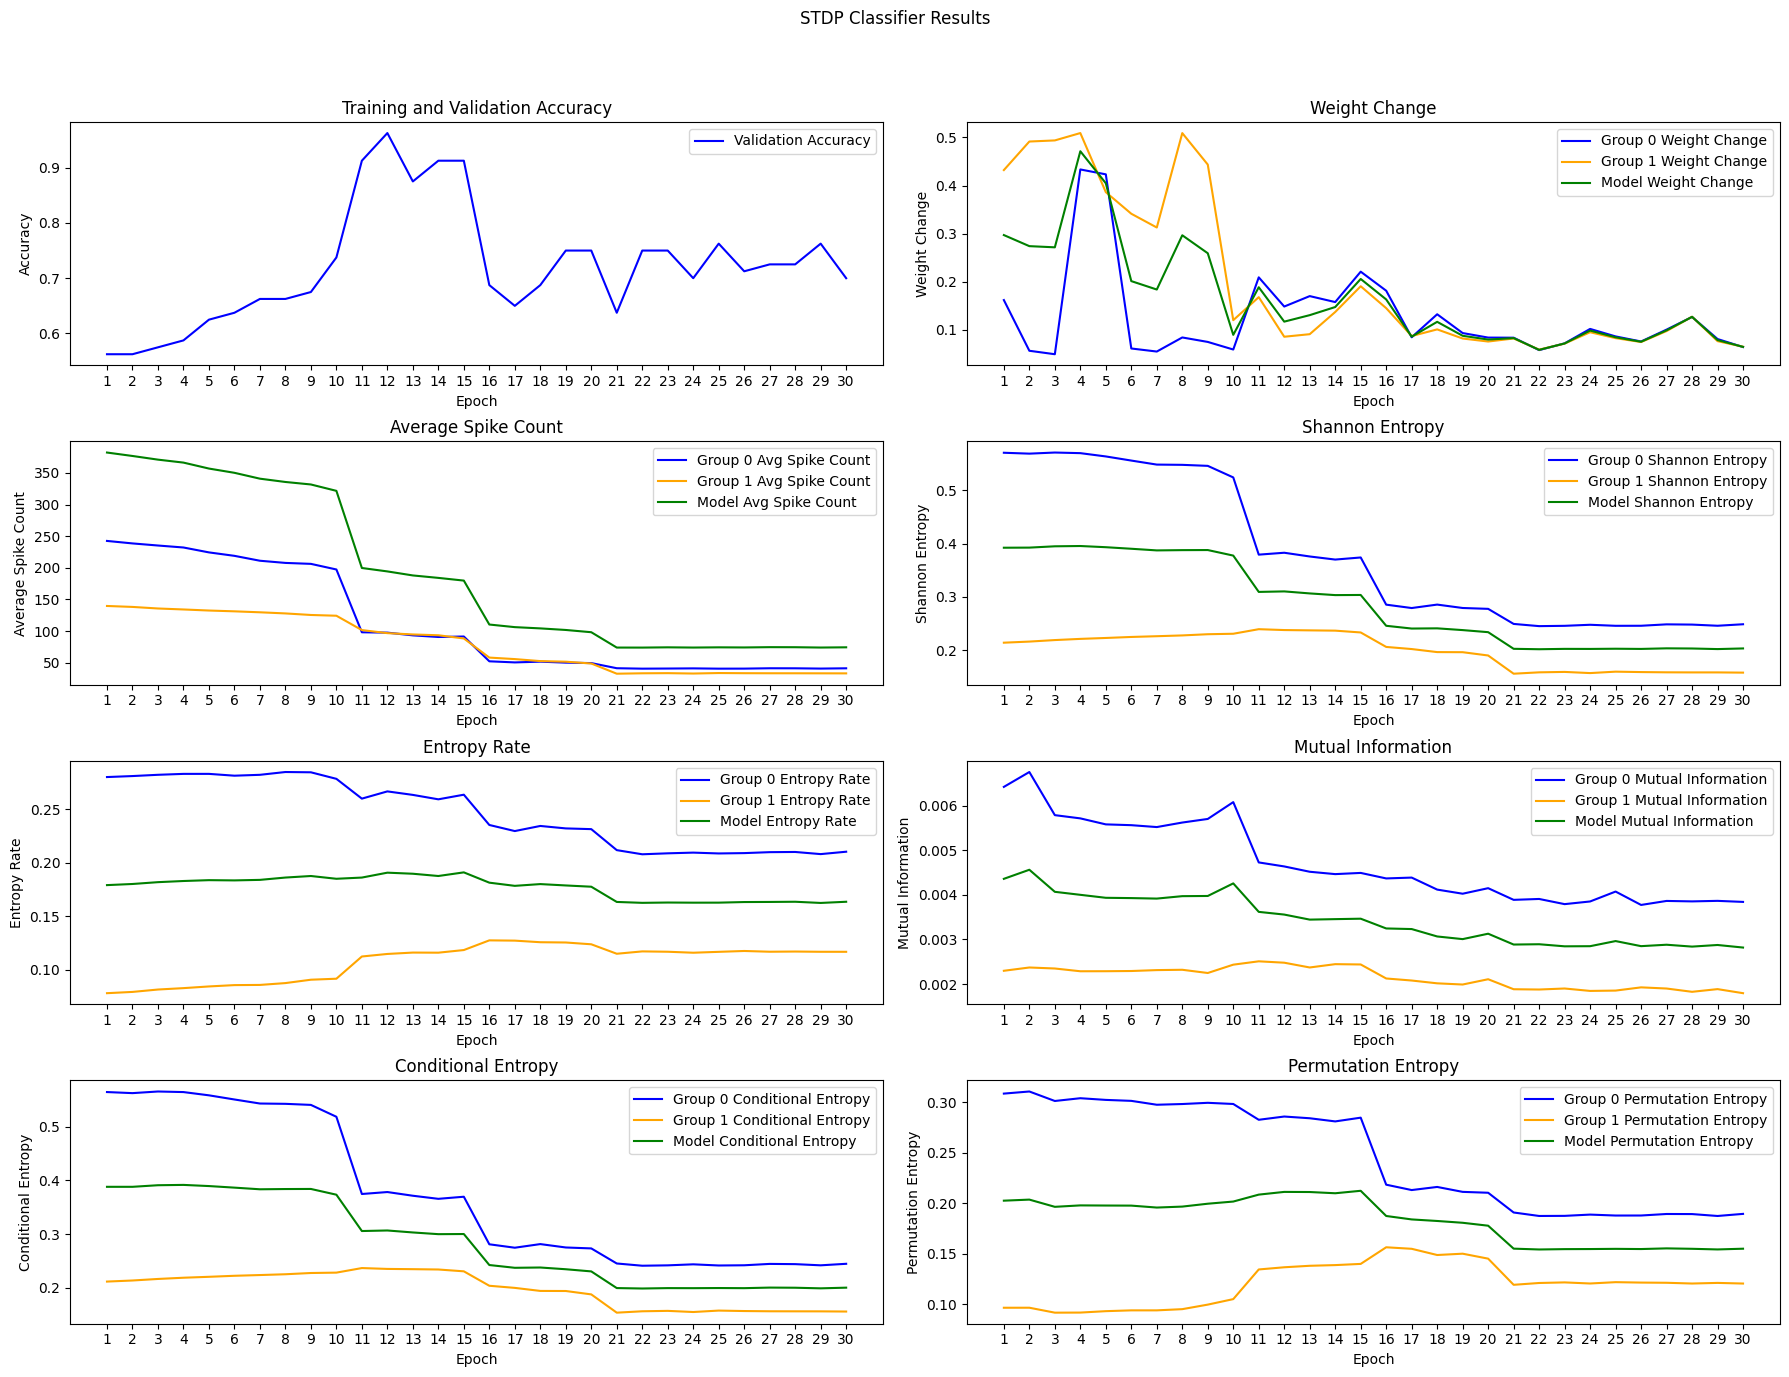

In [25]:
epoch_axis = np.arange(1, params["epochs"] + 1, 1)

# Plot the model results
plt.figure(figsize=(18, 14))

plt.subplot(4, 2, 1)
plt.plot(epoch_axis, val_acc_count, label='Validation Accuracy', color='blue')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(epoch_axis, group0_shannon_entropy, label='Group 0 Shannon Entropy', color='blue')
plt.plot(epoch_axis, group1_shannon_entropy, label='Group 1 Shannon Entropy', color='orange')
plt.plot(epoch_axis, model_shannon_entropy, label='Model Shannon Entropy', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(epoch_axis, group0_entropy_rate, label='Group 0 Entropy Rate', color='blue')
plt.plot(epoch_axis, group1_entropy_rate, label='Group 1 Entropy Rate', color='orange')
plt.plot(epoch_axis, model_entropy_rate, label='Model Entropy Rate', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Entropy Rate')
plt.title('Entropy Rate')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(epoch_axis, group0_mutual_information, label='Group 0 Mutual Information', color='blue')
plt.plot(epoch_axis, group1_mutual_information, label='Group 1 Mutual Information', color='orange')
plt.plot(epoch_axis, model_mutual_information, label='Model Mutual Information', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Mutual Information')
plt.title('Mutual Information')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(epoch_axis, group0_conditional_entropy, label='Group 0 Conditional Entropy', color='blue')
plt.plot(epoch_axis, group1_conditional_entropy, label='Group 1 Conditional Entropy', color='orange')
plt.plot(epoch_axis, model_conditional_entropy, label='Model Conditional Entropy', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Conditional Entropy')
plt.title('Conditional Entropy')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(epoch_axis, group0_avg_spike_count, label='Group 0 Avg Spike Count', color='blue')
plt.plot(epoch_axis, group1_avg_spike_count, label='Group 1 Avg Spike Count', color='orange')
plt.plot(epoch_axis, model_avg_spike_count, label='Model Avg Spike Count', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Average Spike Count')
plt.title('Average Spike Count')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(epoch_axis, group0_permutation_entropy, label='Group 0 Permutation Entropy', color='blue')
plt.plot(epoch_axis, group1_permutation_entropy, label='Group 1 Permutation Entropy', color='orange')
plt.plot(epoch_axis, model_permutation_entropy, label='Model Permutation Entropy', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Permutation Entropy')
plt.title('Permutation Entropy')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(epoch_axis, _group0_weight_changes, label='Group 0 Weight Change', color='blue')
plt.plot(epoch_axis, _group1_weight_changes, label='Group 1 Weight Change', color='orange')
plt.plot(epoch_axis, _model_weight_changes, label='Model Weight Change', color='green')
plt.xticks(np.arange(1, params["epochs"] + 1, 1))
plt.xlabel('Epoch')
plt.ylabel('Weight Change')
plt.title('Weight Change')
plt.legend()

plt.suptitle('STDP Classifier Results')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

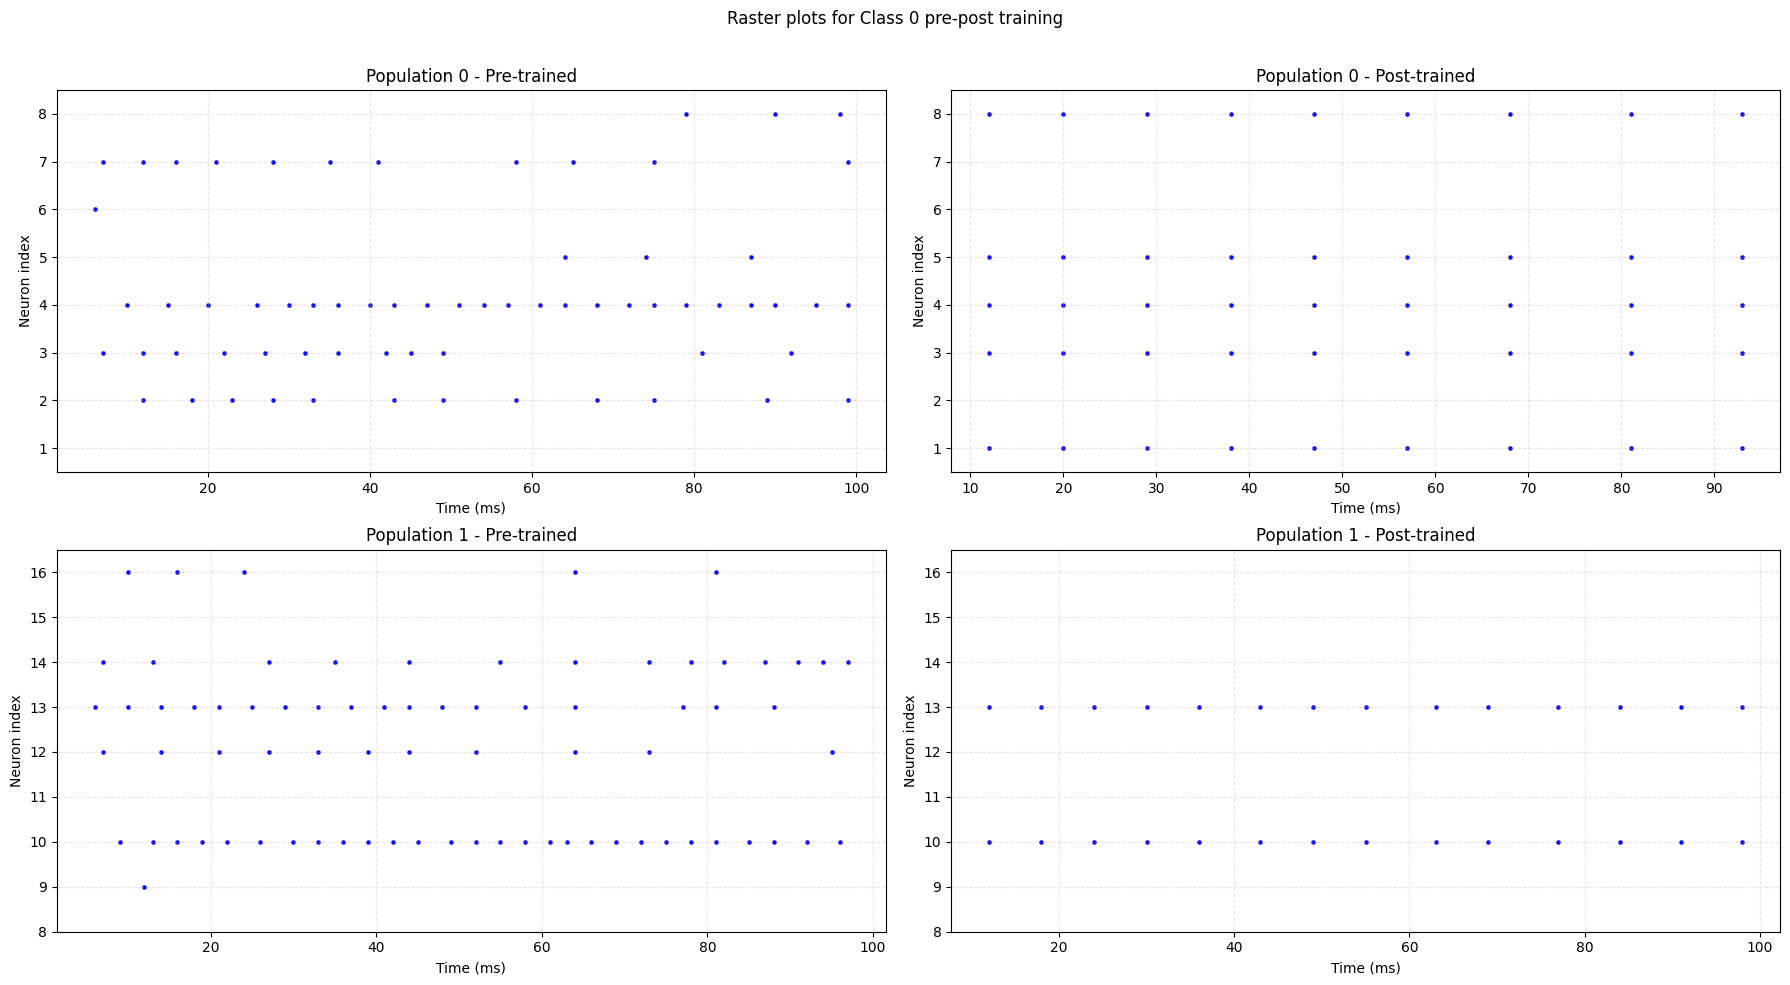

In [30]:
out_ids_class0_pre, out_t_class0_pre = raster_class0[0]
out_ids_class0_post, out_t_class0_post = raster_class0[1]

pop0_mask_pre = out_ids_class0_pre < params["out_pop"]
pop1_mask_pre = out_ids_class0_pre >= params["out_pop"]

pop0_mask_post = out_ids_class0_post < params["out_pop"]
pop1_mask_post = out_ids_class0_post >= params["out_pop"]

# class 0 Raster plots
plt.figure(figsize=(18, 10))

# Population 0
plt.subplot(2, 2, 1)
plt.scatter(out_t_class0_pre[pop0_mask_pre], out_ids_class0_pre[pop0_mask_pre]+1, s=5, color='blue')
plt.ylim(0.5, 8.5)
plt.yticks(np.arange(1, 9, 1))
plt.title("Population 0 - Pre-trained")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.grid(True, linestyle='--', alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(out_t_class0_post[pop0_mask_post], out_ids_class0_post[pop0_mask_post]+1, s=5, color='blue')
plt.ylim(0.5, 8.5)
plt.yticks(np.arange(1, 9, 1))
plt.title("Population 0 - Post-trained")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.grid(True, linestyle='--', alpha=0.3)

# Population 1
plt.subplot(2, 2, 3)
plt.scatter(out_t_class0_pre[pop1_mask_pre], out_ids_class0_pre[pop1_mask_pre]+1, s=5, color='blue')
plt.ylim(8.5, 16.5)
plt.yticks(np.arange(8, 17, 1))
plt.title("Population 1 - Pre-trained")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.grid(True, linestyle='--', alpha=0.3)

plt.subplot(2, 2, 4)
plt.scatter(out_t_class0_post[pop1_mask_post], out_ids_class0_post[pop1_mask_post]+1, s=5, color='blue')
plt.ylim(8.5, 16.5)
plt.yticks(np.arange(8, 17, 1))
plt.title("Population 1 - Post-trained")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Raster plots for Class 0 pre-post training')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


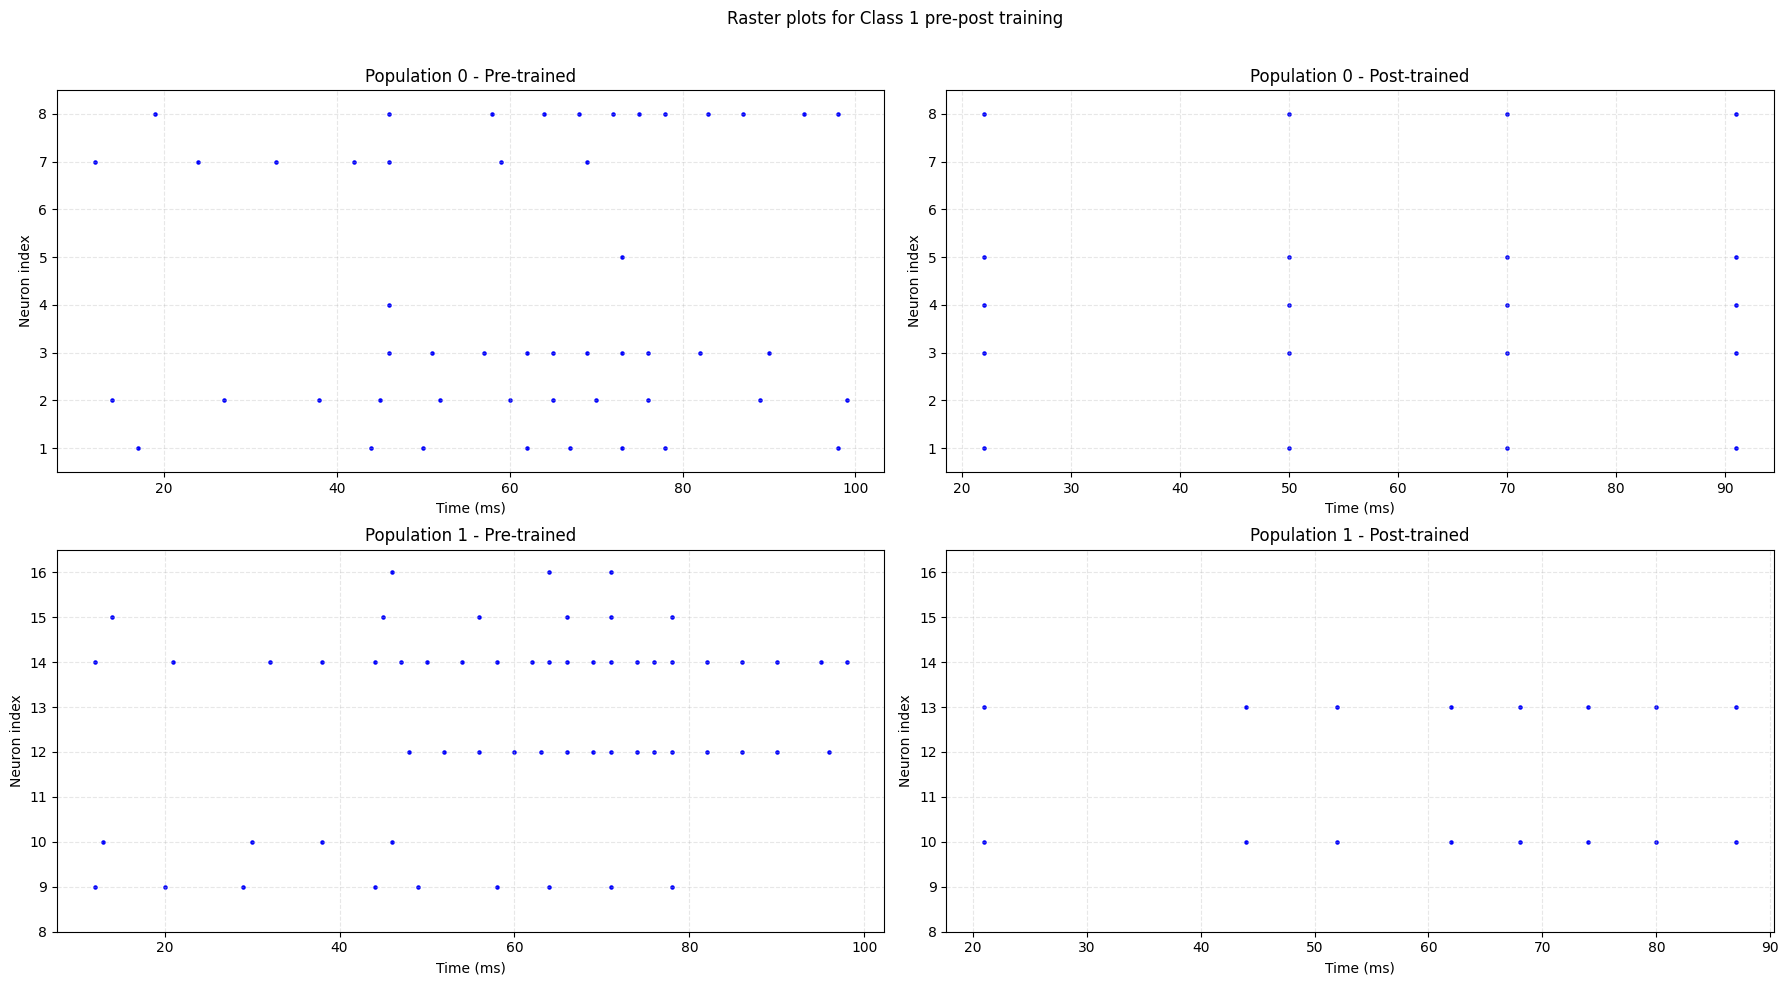

In [31]:
out_ids_class1_pre, out_t_class1_pre = raster_class1[0]
out_ids_class1_post, out_t_class1_post = raster_class1[1]

pop0_mask_pre = out_ids_class1_pre < params["out_pop"]
pop1_mask_pre = out_ids_class1_pre >= params["out_pop"]

pop0_mask_post = out_ids_class1_post < params["out_pop"]
pop1_mask_post = out_ids_class1_post >= params["out_pop"]

# class 1 Raster plots
plt.figure(figsize=(18, 10))

# Population 0
plt.subplot(2, 2, 1)
plt.scatter(out_t_class1_pre[pop0_mask_pre], out_ids_class1_pre[pop0_mask_pre]+1, s=5, color='blue')
plt.ylim(0.5, 8.5)
plt.yticks(np.arange(1, 9, 1))
plt.title("Population 0 - Pre-trained")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.grid(True, linestyle='--', alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(out_t_class1_post[pop0_mask_post], out_ids_class1_post[pop0_mask_post]+1, s=5, color='blue')
plt.ylim(0.5, 8.5)
plt.yticks(np.arange(1, 9, 1))
plt.title("Population 0 - Post-trained")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.grid(True, linestyle='--', alpha=0.3)

# Population 1
plt.subplot(2, 2, 3)
plt.scatter(out_t_class1_pre[pop1_mask_pre], out_ids_class1_pre[pop1_mask_pre]+1, s=5, color='blue')
plt.ylim(8.5, 16.5)
plt.yticks(np.arange(8, 17, 1))
plt.title("Population 1 - Pre-trained")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.grid(True, linestyle='--', alpha=0.3)

plt.subplot(2, 2, 4)
plt.scatter(out_t_class1_post[pop1_mask_post], out_ids_class1_post[pop1_mask_post]+1, s=5, color='blue')
plt.ylim(8.5, 16.5)
plt.yticks(np.arange(8, 17, 1))
plt.title("Population 1 - Post-trained")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Raster plots for Class 1 pre-post training')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()